# Procesamiento Digital de Imagenes - TP2

## Constants and functions

Importing libraries

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

Functions and constants

In [ ]:
YIQ_transform_matrix = np.mat('0.299 0.587 0.114; 0.595716 -0.274453 -0.321263; 0.211456 -0.522591 0.311135')

### RGB a YIQ

In [ ]:
def RGB_to_YIQ(image_RGB):
  # x and y dimensions
  x_size = image_RGB.shape[0]
  y_size = image_RGB.shape[1]

  # Normalizing every pixel
  normalized_imaged = image_RGB/255

  # Converting from RGB to YIQ
  image_yiq = np.zeros([x_size, y_size, 3])

  for px in range(0, x_size):
    for py in range(0, y_size):
      image_yiq[px, py, :] = np.dot( YIQ_transform_matrix, normalized_imaged[px , py ,:] )
  return image_yiq

### YIQ a RGB

In [ ]:
def YIQ_to_RGB(image_YIQ):
  # x and y dimensions
  x_size = image_YIQ.shape[0]
  y_size = image_YIQ.shape[1]

  # Matrix to transform to RGB
  RGB_transform_matrix = np.linalg.inv(YIQ_transform_matrix)

  # Converting from YIQ to RGB
  image_rgb = np.zeros([x_size, y_size, 3])

  for px in range(0, x_size):
    for py in range(0, y_size):
      image_rgb[px, py, :] = np.dot( RGB_transform_matrix, image_YIQ[px , py ,:] )
  return image_rgb

### Y, I and Q values (to index)

In [ ]:
Y = 0; I = 1; Q = 2

### Ic and Qc interpolation

In [ ]:
def interpolate(image_a_YIQ, image_b_YIQ, image_c):
  denominator = image_a_YIQ[:,:,Y] + image_b_YIQ[:,:,Y]
  image_c[:,:,1] = (image_a_YIQ[:,:,Y]*image_a_YIQ[:,:,I] + image_b_YIQ[:,:,Y]*image_b_YIQ[:,:,I])/denominator
  image_c[:,:,2] = (image_a_YIQ[:,:,Y]*image_a_YIQ[:,:,Q] + image_b_YIQ[:,:,Y]*image_b_YIQ[:,:,Q])/denominator
  return image_c

In [ ]:
def diff_interpolate(image_a_YIQ, image_b_YIQ, image_c):
  denominator = image_a_YIQ[:,:,Y] + image_b_YIQ[:,:,Y]
  image_c[:,:,I] = (image_a_YIQ[:,:,Y]*image_a_YIQ[:,:,I] - image_b_YIQ[:,:,Y]*image_b_YIQ[:,:,I])/denominator
  image_c[:,:,Q] = (image_a_YIQ[:,:,Y]*image_a_YIQ[:,:,Q] - image_b_YIQ[:,:,Y]*image_b_YIQ[:,:,Q])/denominator
  image_c[:,:,I] = np.clip(image_c[:,:,I], a_min = -0.5957, a_max = 0.5957)
  image_c[:,:,Q] = np.clip(image_c[:,:,Q], a_min = -0.5226, a_max = 0.5226)
  return image_c

### Sum RGB

In [ ]:
def sum_rgb(image_a, image_b):
  image_c = np.zeros([image_a.shape[0], image_a.shape[1], 3], dtype = np.uint8)
  image_c.fill(255)

  # Sum
  image_c[:,:,0] = image_a[:,:,0]/2 + image_b[:,:,0]/2
  image_c[:,:,1] = image_a[:,:,1]/2 + image_b[:,:,1]/2
  image_c[:,:,2] = image_a[:,:,2]/2 + image_b[:,:,2]/2

  return image_c

### Sum YIQ

In [ ]:
def sum_yiq(image_a, image_b):
  # Transforming to YIQ
  image_a_YIQ = RGB_to_YIQ(image_a)
  image_b_YIQ = RGB_to_YIQ(image_b)

  image_c = np.zeros([image_a.shape[0], image_a.shape[1], 3])
  image_c.fill(255)

  # Ic and Qc interpolation
  image_c = interpolate(image_a_YIQ, image_b_YIQ, image_c)
  
  # Averaging Y
  image_c[:,:,Y] = (image_a_YIQ[:,:,Y] + image_b_YIQ[:,:,Y])/2

  return YIQ_to_RGB(image_c)

### If-Lighter

In [ ]:
def if_lighter(image_a, image_b):
  # Transforming to YIQ
  image_a_YIQ = RGB_to_YIQ(image_a)
  image_b_YIQ = RGB_to_YIQ(image_b)
    
  image_c = np.zeros([image_a.shape[0], image_a.shape[1], 3])
  
  # If light
  for p_y in range(image_a.shape[0]):
      for p_x in range(image_a.shape[1]):
          if image_a_YIQ[p_y,p_x,Y] >  image_b_YIQ[p_y,p_x,Y]:
              image_c[p_y, p_x, :] = image_a_YIQ[p_y, p_x, :]
          else: 
              image_c[p_y, p_x, :] = image_b_YIQ[p_y, p_x, :]
  return YIQ_to_RGB(image_c)

### If-Darker

In [ ]:
def if_darker(image_a, image_b):
  # Transforming to YIQ
  image_a_YIQ = RGB_to_YIQ(image_a)
  image_b_YIQ = RGB_to_YIQ(image_b)
    
  image_c = np.zeros([image_a.shape[0], image_a.shape[1], 3])

  # If darker
  for p_y in range(image_a.shape[0]):
      for p_x in range(image_a.shape[1]):
          if image_a_YIQ[p_y,p_x,Y] <  image_b_YIQ[p_y,p_x,Y]:
              image_c[p_y, p_x, :] = image_a_YIQ[p_y, p_x, :]
          else: 
              image_c[p_y, p_x, :] = image_b_YIQ[p_y, p_x, :]
  return YIQ_to_RGB(image_c)

### Diff RGB

In [ ]:
def diff_rgb(image_a, image_b):
  image_c = np.zeros([image_a.shape[0], image_a.shape[1], 3], dtype = np.uint8)
  image_c.fill(255)

  # Diff
  image_c[:,:,0] = ( image_a[:,:,0]/2 - image_b[:,:,0]/2 ) + 127
  image_c[:,:,1] = ( image_a[:,:,1]/2 - image_b[:,:,1]/2 ) + 127
  image_c[:,:,2] = ( image_a[:,:,2]/2 - image_b[:,:,2]/2 ) + 127

  return image_c

### Diff YIQ

In [ ]:
def diff_yiq(image_a, image_b):
  # Transforming to YIQ
  image_a_YIQ = RGB_to_YIQ(image_a)
  image_b_YIQ = RGB_to_YIQ(image_b)

  image_c = np.zeros([image_a.shape[0], image_a.shape[1], 3])
  image_c.fill(255)
  
  # Ic and Qc interpolation
  image_c = diff_interpolate(image_a_YIQ, image_b_YIQ, image_c)

  # Averaging Y
  image_c[:,:,Y] = (image_a_YIQ[:,:,Y]/2 - image_b_YIQ[:,:,Y]/2) + 0.5

  return YIQ_to_RGB(image_c)

## Images loading and operations

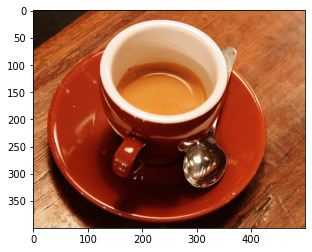

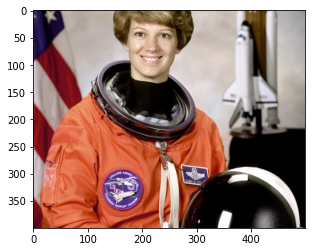

In [ ]:
image_a = imageio.imread('imageio:coffee.png')[:, 50:550, :]
image_b = imageio.imread('imageio:astronaut.png')[56:456, 6:506, :]

plt.imshow(image_a)
plt.show()

plt.imshow(image_b)
plt.show()

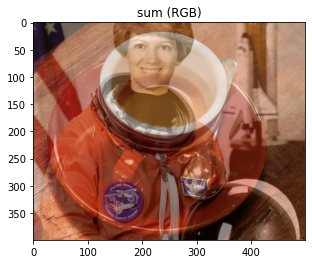

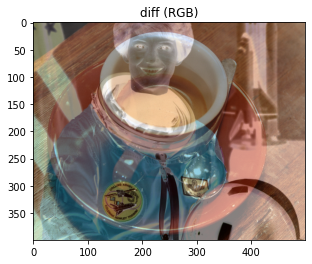

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


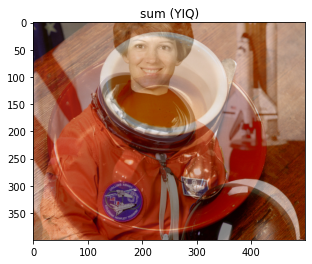

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


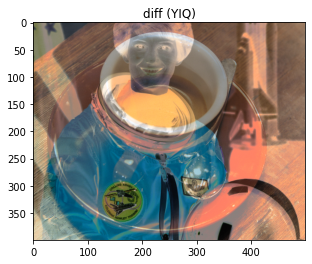

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


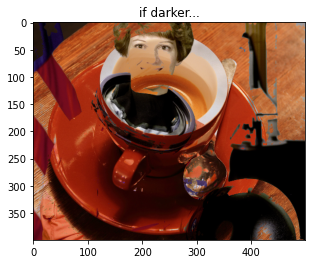

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


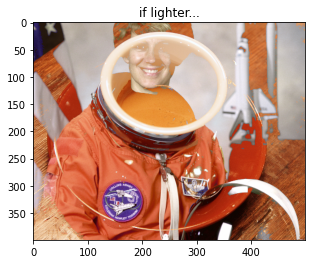

In [ ]:
plt.imshow(sum_rgb(image_a, image_b))
plt.title('sum (RGB)')
plt.show()

plt.imshow(diff_rgb(image_a, image_b))
plt.title('diff (RGB)')
plt.show()

plt.imshow(sum_yiq(image_a, image_b))
plt.title('sum (YIQ)')
plt.show()

plt.imshow(diff_yiq(image_a, image_b))
plt.title('diff (YIQ)')
plt.show()

plt.imshow(if_darker(image_a, image_b))
plt.title('if darker...')
plt.show()

plt.imshow(if_lighter(image_a, image_b))
plt.title('if lighter...')
plt.show()

This functions, for example the difference between images, can be used in PCB Manufacturing to find errors between the desire pcb and the printed one. Another use case, but for the sum, may be to mark some area in a map.